# **Table of Contents**

1. Global Constants

2. Dependences

3. Human Animal Classification

    3.1.  Dataset 

    3.2.  Image Augmentation

    3.3.  Machine Learning
    
    3.4.  Model Evaluation

    3.5.  Save csv
  
4. Animal Emotion

    4.1.  Dataset 

    4.2.  Image Augmentation

    4.3.  Machine Learning
    
    4.4.  Model Evaluation

    4.5.  Save csv

# **Abstract**
The main goal of the project is to use using computer vision processing to distinguish between animals and humans. Additionally, it incorporates an emotion detection module, analyzing facial expressions to identify animal emotions accurately.

# **1. Global Constants**

In [67]:
emo_data_dir = 'emotion_dataset'
type_data_dir = 'animal_human_dataset'

RANDOM_SEED = 42

# **2. Dependences**

In [68]:
#import useful package
import os
import itertools

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

In [69]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers.legacy import RMSprop
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.models import load_model


# **3. Human Animal Classification**

## **3.1.** Dataset

### **3.1.1.** Analizing 

In [70]:
"""
This function generate a dictionary with path of an image and its label.
"""
def generate_data_paths(data_dir):    
    image_path_label = {}
    folds = os.listdir(data_dir)

    for fold in folds:
        if fold.startswith('.') or not os.path.isdir(os.path.join(data_dir, fold)):
            continue
            
        foldpath = os.path.join(data_dir, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            image_path_label[fpath] = fold
            
    return image_path_label

In [71]:
"""
This function tells how many images contain in each folder.
"""
def classes_count(df, name= 'dataset'):
    print(f"The {name} has: ")
    for name in df['label'].unique():
        num_class = len(df['label'][df['label'] == name])
        print(f"Class '{name}' has {num_class} images")

In [72]:
image_path_label = generate_data_paths(type_data_dir)
df_type = pd.DataFrame(list(image_path_label.items()), columns=['path', 'label'])
display(df_type)

,path,label
0,animal_human_dataset/pet/63.jpg,pet
1,animal_human_dataset/pet/36 copia.jpg,pet
2,animal_human_dataset/pet/77.jpg,pet
3,animal_human_dataset/pet/aug-62-081 copia.jpg,pet
4,animal_human_dataset/pet/aug-135-78.jpg,pet
...,...,...
2025,animal_human_dataset/human/1 (322).jpg,human
2026,animal_human_dataset/human/1 (772).jpg,human
2027,animal_human_dataset/human/1 (288).jpg,human
2028,animal_human_dataset/human/1 (119).png,human


In [73]:
print(f"The Human and Pet dataset has {df_type.shape[0]} images divided in {len(df_type['label'].unique())} classes")

The Human and Pet dataset has 2030 images divided in 2 classes


In [74]:
classes_count(df_type, name='Human and Pet dataset')

The Human and Pet dataset has: 
Class 'pet' has 1001 images
Class 'human' has 1029 images


### **3.1.2.** Split Dataframe


In [75]:
def split_dataframe(df):
    train_df, dummy_df = train_test_split(df, train_size= 0.7, shuffle= True, random_state= RANDOM_SEED)
    valid_df, test_df = train_test_split(dummy_df, train_size= 0.6, shuffle= True, random_state= RANDOM_SEED)
    return train_df, valid_df, test_df

In [76]:
train_df_type, valid_df_type, test_df_type = split_dataframe(df_type)

In [77]:
def num_of_examples(df, name='df'):
    print(f"The {name} dataset has {df.shape[0]} images.")

In [78]:
num_of_examples(train_df_type, 'Human and Pet Training')
num_of_examples(valid_df_type, 'Human and Pet Validation')
num_of_examples(test_df_type, 'Human and Pet Testing')

The Human and Pet Training dataset has 1421 images.
The Human and Pet Validation dataset has 365 images.
The Human and Pet Testing dataset has 244 images.


In [81]:
classes_count(train_df_type, 'training dataset')

The training dataset has: 
Class 'human' has 725 images
Class 'pet' has 696 images


## **3.2.** Image Augmentation

In [34]:
def plot_generator_images(data_generator, num_images=4):
    g_dict = data_generator.class_indices
    classes = list(g_dict.keys())
    images, labels = next(data_generator)
    
    plt.figure(figsize=(12, 12))

    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        image = images[i] / 255
        plt.imshow(image)
        
        if len(labels[i]) == 1:
            # For binary classification without one-hot encoding
            index = int(labels[i])
        else:
            # For binary classification with one-hot encoding or multi-class classification
            index = np.argmax(labels[i])
            
        class_name = classes[index]
        plt.title(class_name, fontsize=12)
        plt.axis('off')
    
    plt.show()

In [35]:
def plot_generator_images(data_generator, num_images=4):
    g_dict = data_generator.class_indices      # defines dictionary {'class': index}
    classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
    images, labels = next(data_generator)  
    
    plt.figure(figsize=(12, 12))

    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        image = images[i] / 255       # scales data to range (0 - 255)
        plt.imshow(image)
        if len(labels[i]) == 1:
            # For binary classification
            index = int(labels[i][0])  # Assuming labels are one-hot encoded
        else:
            # For multi-class classification
            index = np.argmax(labels[i])

        if index >= len(classes):
            # Ensure the index is within the range of available classes
            index = 0
            
        class_name = classes[index]   # get class of image
        plt.title(class_name, fontsize= 12)
        plt.axis('off')
        
    
    plt.show()    # get a batch size samples from the generator

In [36]:
def create_and_plot_data_generators(train_df, valid_df, test_df, batch_size=16, img_size=(224, 224), channels=3):
    # Calculate a recommended test batch size based on the length of the test dataset
    ts_length = len(test_df)
    test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))

    # Define a function for data augmentation that takes an image and returns it unchanged
    def scalar(img):
        return img

    # Create ImageDataGenerator objects for training, validation, and testing with data augmentation settings
    tr_gen = ImageDataGenerator(
        preprocessing_function=scalar,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        brightness_range=[0.4, 0.6],
        zoom_range=0.3,
        horizontal_flip=True,
        vertical_flip=True
    )

    ts_gen = ImageDataGenerator(
        preprocessing_function=scalar,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        brightness_range=[0.4, 0.6],
        zoom_range=0.3,
        horizontal_flip=True,
        vertical_flip=True
    )

    train_gen = tr_gen.flow_from_dataframe(
        train_df,
        x_col='path',
        y_col='label',
        target_size=img_size,
        class_mode='categorical',
        color_mode='rgb',
        shuffle=True,
        batch_size=batch_size
    )

    valid_gen = ts_gen.flow_from_dataframe(
        valid_df,
        x_col='path',
        y_col='label',
        target_size=img_size,
        class_mode='categorical',
        color_mode='rgb',
        shuffle=True,
        batch_size=batch_size
    )

    # Note: we will use a custom test_batch_size, and make shuffle=False
    test_gen = ts_gen.flow_from_dataframe(
        test_df,
        x_col='path',
        y_col='label',
        target_size=img_size,
        class_mode='categorical',
        color_mode='rgb',
        shuffle=False,
        batch_size=test_batch_size
    )

    # Plot images from the training generator
    print("Training Generator:")
    plot_generator_images(train_gen)

    # Plot images from the validation generator
    print("Validation Generator:")
    plot_generator_images(valid_gen)

    # Plot images from the test generator
    print("Test Generator:")
    plot_generator_images(test_gen)

    return train_gen, valid_gen, test_gen


Found 1419 validated image filenames belonging to 2 classes.
Found 365 validated image filenames belonging to 2 classes.
Found 244 validated image filenames belonging to 2 classes.


/Users/jngelena/Library/Python/3.9/lib/python/site-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 2 invalid image filename(s) in x_col="path". These filename(s) will be ignored.
  warnings.warn(


Training Generator:


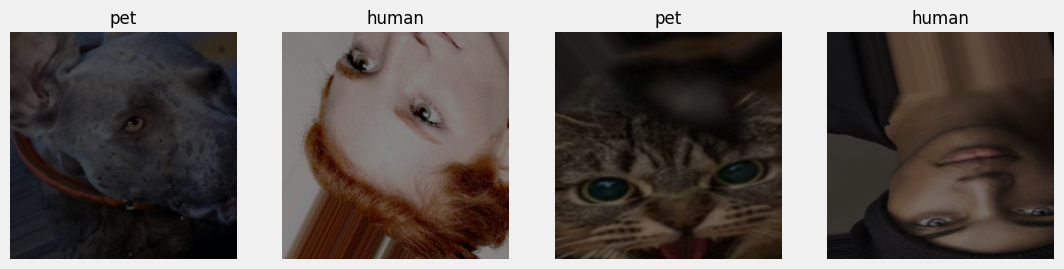

Validation Generator:


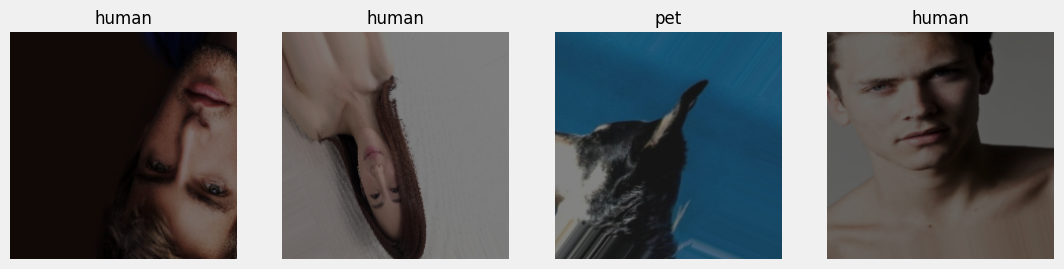

Test Generator:


/Users/jngelena/Library/Python/3.9/lib/python/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


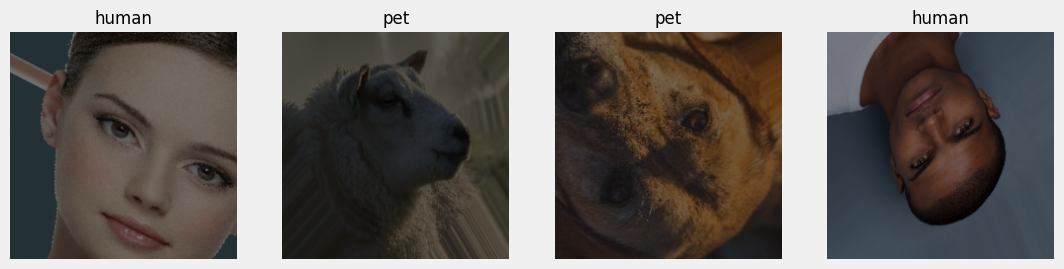

In [80]:
train_gen_type, valid_gen_type, test_gen_type = create_and_plot_data_generators(train_df_type, valid_df_type, test_df_type)

## **3.3.** Machine Learning

In [38]:
def create_efficientnet_model(img_size=(224, 224), channels=3, class_count=10):
    # Input shape
    img_shape = (img_size[0], img_size[1], channels)

    # Create pre-trained model (EfficientNetB5 in this case)
    base_model = tf.keras.applications.efficientnet.EfficientNetB5(include_top=False, weights='imagenet', input_shape=img_shape, pooling='max')
    base_model.trainable = False

    # Build the model
    model = Sequential([
        base_model,
        BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001),
        Dense(256, activation='relu'),
        Dense(128, kernel_regularizer= regularizers.l2(l=0.016), activity_regularizer=regularizers.l1(0.006),
              bias_regularizer=regularizers.l1(0.006), activation='relu'),
        Dropout(rate=0.45, seed=RANDOM_SEED),
        Dense(class_count, activation='softmax')
    ])
    model.summary()

    # Set the training parameters
    model.compile(optimizer = RMSprop(learning_rate=0.0001), 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

    return model

In [39]:
class_count_type = len(list(train_gen_type.class_indices.keys()))
model_type = create_efficientnet_model(class_count=class_count_type)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb5 (Functional  (None, 2048)              28513527  
 )                                                               
                                                                 
 batch_normalization_1 (Bat  (None, 2048)              8192      
 chNormalization)                                                
                                                                 
 dense_3 (Dense)             (None, 256)               524544    
                                                                 
 dense_4 (Dense)             (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 2)                

In [20]:
batch_size = 16   # set batch size for training
history_type = model_type.fit(x=train_gen_type,
                    epochs= 10,
                    verbose= 1,
                    validation_data= valid_gen_type, 
                    validation_steps= None,
                    shuffle= False)

Epoch 1/10
89/89 [==============================] - 73s 757ms/step - loss: 3.2163 - accuracy: 0.8506 - val_loss: 2.8873 - val_accuracy: 0.9507
Epoch 2/10
89/89 [==============================] - 66s 745ms/step - loss: 2.6657 - accuracy: 0.9605 - val_loss: 2.4195 - val_accuracy: 0.9781
Epoch 3/10
89/89 [==============================] - 67s 752ms/step - loss: 2.2783 - accuracy: 0.9767 - val_loss: 2.0402 - val_accuracy: 0.9945
Epoch 4/10
89/89 [==============================] - 67s 758ms/step - loss: 1.9325 - accuracy: 0.9796 - val_loss: 1.7185 - val_accuracy: 0.9973
Epoch 5/10
89/89 [==============================] - 68s 760ms/step - loss: 1.6382 - accuracy: 0.9789 - val_loss: 1.4417 - val_accuracy: 1.0000
Epoch 6/10
89/89 [==============================] - 68s 768ms/step - loss: 1.3582 - accuracy: 0.9901 - val_loss: 1.1900 - val_accuracy: 1.0000
Epoch 7/10
89/89 [==============================] - 69s 770ms/step - loss: 1.1421 - accuracy: 0.9831 - val_loss: 0.9872 - val_accuracy: 0.9973

In [40]:
def plot_training_history(history):
    tr_acc = history.history['accuracy']
    tr_loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]
    Epochs = [i+1 for i in range(len(tr_acc))]
    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}'

    # Plot training history
    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')

    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label='Training loss')
    plt.plot(Epochs, val_loss, 'g', label='Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label='Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s=150, c='blue', label=acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout
    plt.show()

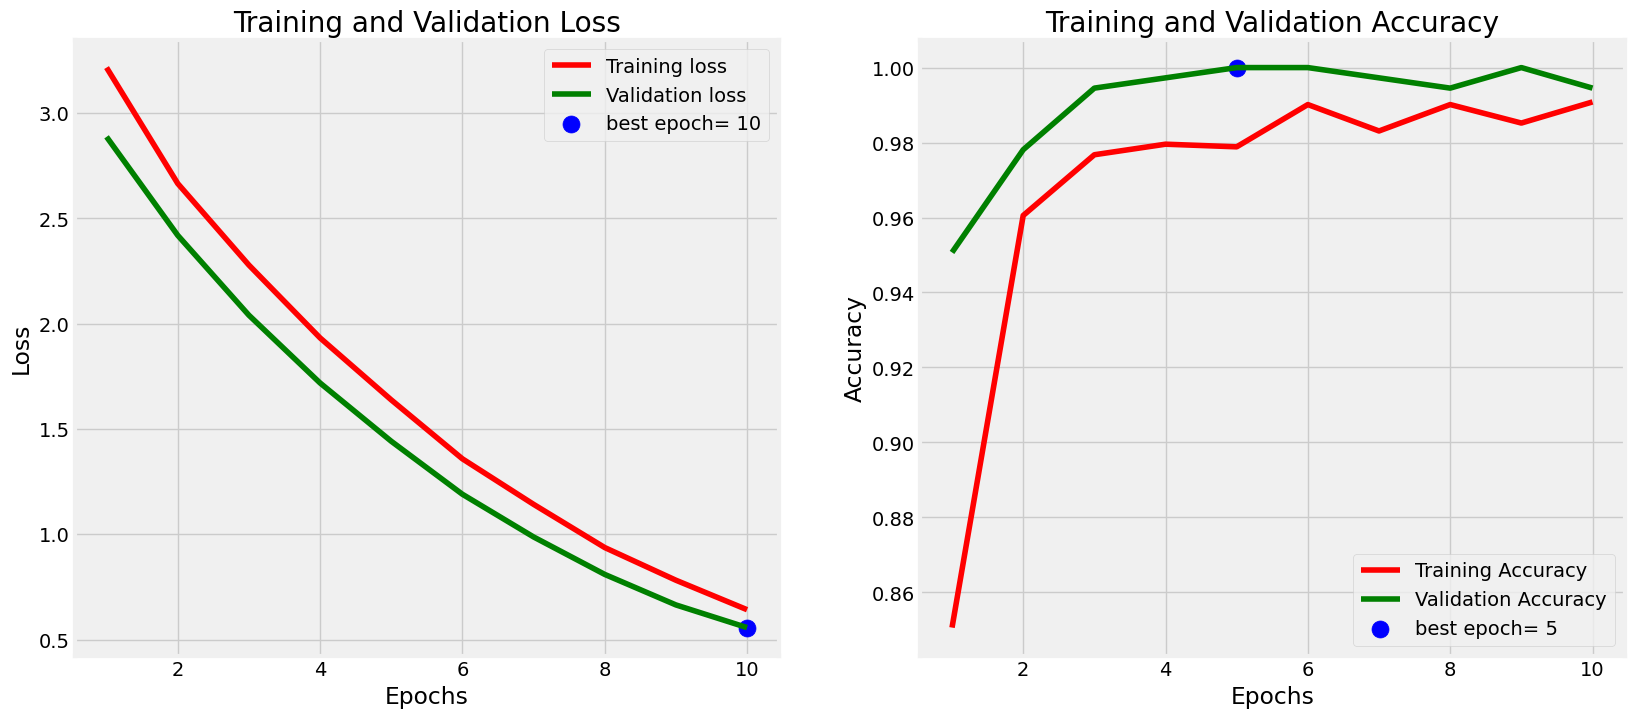

In [41]:
plot_training_history(history_type)

## **3.4.** Model Evaluation

In [42]:
def evaluate_model(model, test_df, train_gen, valid_gen, test_gen):
    ts_length = len(test_df)
    test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
    test_steps = ts_length // test_batch_size

    train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
    valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
    test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

    print('Train Loss: ', train_score[0])
    print('Train Accuracy: ', train_score[1])
    print('-' * 20)
    print('Test Loss: ', test_score[0])
    print('Test Accuracy: ', test_score[1])

In [43]:
evaluate_model(model_type, test_df_type, train_gen_type, valid_gen_type, test_gen_type)

/Users/jngelena/Library/Python/3.9/lib/python/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


4/4 [==============================] - 9s 2s/step - loss: 5.6676 - accuracy: 0.4344
Train Loss:  5.623764991760254
Train Accuracy:  0.484375
--------------------
Test Loss:  5.667642593383789
Test Accuracy:  0.4344262182712555


In [44]:
preds_type = model_type.predict(test_gen_type)
y_pred_type = np.argmax(preds_type, axis=1)

4/4 [==============================] - 10s 2s/step


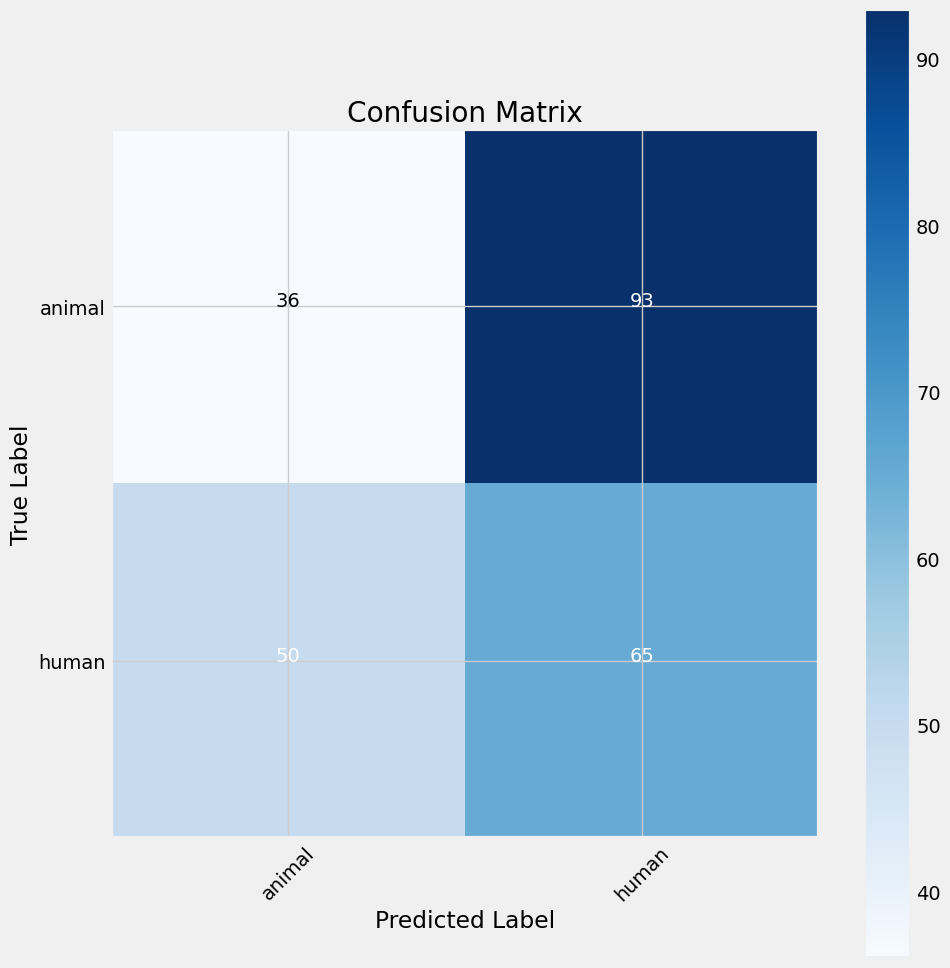

In [45]:
g_dict = test_gen_type.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen_type.classes, y_pred_type)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [46]:
# Classification report
print(classification_report(test_gen_type.classes, y_pred_type, target_names= classes))

              precision    recall  f1-score   support

      animal       0.42      0.28      0.33       129
       human       0.41      0.57      0.48       115

    accuracy                           0.41       244
   macro avg       0.41      0.42      0.41       244
weighted avg       0.42      0.41      0.40       244



## **3.5.** Save Model

In [47]:
model_type.save('Animal_Human_model.h5')

#import pickle

#with open('Animal_Human_model.pkl', 'wb') as file:
#    pickle.dump(model_type, file)

# **4. Animal Emotion**

## **4.1.** Dataset

### **4.1.1.** Analizing 

In [55]:
image_path_label = generate_data_paths(emo_data_dir)
df_emotion = pd.DataFrame(list(image_path_label.items()), columns=['path', 'label'])
display(df_emotion)

,path,label
0,emotion_dataset/Happy/aug-70-085.jpg,Happy
1,emotion_dataset/Happy/aug-121-039.jpg,Happy
2,emotion_dataset/Happy/aug-78-097.jpg,Happy
3,emotion_dataset/Happy/aug-68-083.jpg,Happy
4,emotion_dataset/Happy/aug-8-012.jpg,Happy
...,...,...
995,emotion_dataset/Angry/aug-10-17.jpg,Angry
996,emotion_dataset/Angry/91.jpg,Angry
997,emotion_dataset/Angry/85.jpg,Angry
998,emotion_dataset/Angry/52.jpg,Angry


In [56]:
print(f"The Pet's emotion dataset has {df_emotion.shape[0]} images divided in {len(df_emotion['label'].unique())} classes")

The Pet emotion dataset has 1000 images divided in 4 classes


In [57]:
classes_count(df_emotion, name="Pet's emotion")

The Pet's emotion has: 
Class 'Happy' has 250 images
Class 'Sad' has 250 images
Class 'Other' has 250 images
Class 'Angry' has 250 images


### **4.1.2.** Split Dataframe


In [58]:
train_df_emo, valid_df_emo, test_df_emo = split_dataframe(df_emotion)

In [59]:
num_of_examples(train_df_emo, "Pet's emotion Training")
num_of_examples(valid_df_emo, "Pet's emotion Validation")
num_of_examples(test_df_emo, "Pet's emotion Testing")

The Pet's emotion Training dataset has 700 images.
The Pet's emotion Validation dataset has 180 images.
The Pet's emotion Testing dataset has 120 images.


In [34]:
classes_count(train_df_emo, 'training dataset')

The training dataset has: 
Class 'Other' has 175 images
Class 'Sad' has 172 images
Class 'Angry' has 175 images
Class 'Happy' has 178 images


## **4.2.** Image Augmentation

Found 700 validated image filenames belonging to 4 classes.
Found 180 validated image filenames belonging to 4 classes.
Found 120 validated image filenames belonging to 4 classes.


Training Generator:


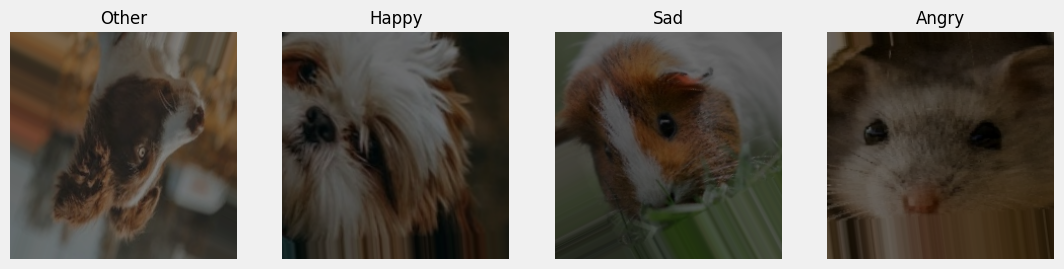

Validation Generator:


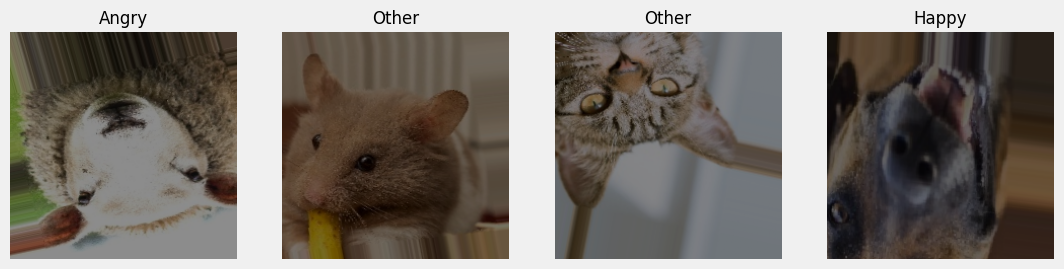

Test Generator:


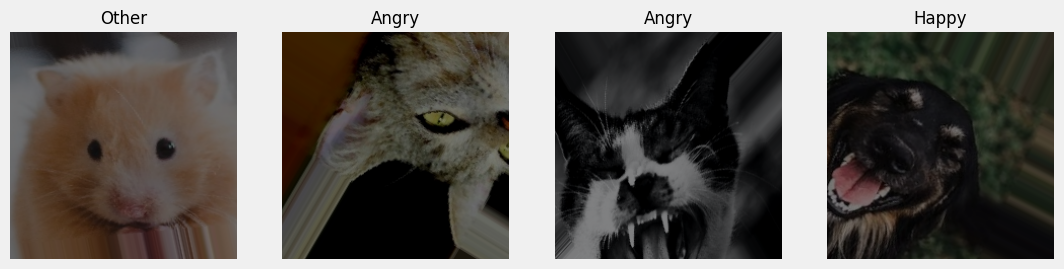

In [35]:
train_gen_emo, valid_gen_emo, test_gen_emo = create_and_plot_data_generators(train_df_emo, valid_df_emo, test_df_emo)

## **4.3.** Machine Learning

In [36]:
class_count_type = len(list(train_gen_emo.class_indices.keys()))
model_emo = create_efficientnet_model(class_count=class_count_type)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb5 (Functional  (None, 2048)              28513527  
 )                                                               
                                                                 
 batch_normalization_1 (Bat  (None, 2048)              8192      
 chNormalization)                                                
                                                                 
 dense_3 (Dense)             (None, 256)               524544    
                                                                 
 dense_4 (Dense)             (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 4)                

In [37]:
batch_size = 16   # set batch size for training
history_emo = model_emo.fit(x=train_gen_emo,
                    epochs= 100,
                    verbose= 1,
                    validation_data= valid_gen_emo, 
                    validation_steps= None,
                    shuffle= False)

Epoch 1/100
44/44 [==============================] - 39s 765ms/step - loss: 4.6538 - accuracy: 0.3200 - val_loss: 4.5457 - val_accuracy: 0.4444
Epoch 2/100
44/44 [==============================] - 33s 747ms/step - loss: 4.2713 - accuracy: 0.4043 - val_loss: 4.1821 - val_accuracy: 0.4611
Epoch 3/100
44/44 [==============================] - 33s 741ms/step - loss: 4.1139 - accuracy: 0.4371 - val_loss: 3.9825 - val_accuracy: 0.4500
Epoch 4/100
44/44 [==============================] - 33s 744ms/step - loss: 3.9582 - accuracy: 0.4700 - val_loss: 3.8335 - val_accuracy: 0.5389
Epoch 5/100
44/44 [==============================] - 33s 746ms/step - loss: 3.8294 - accuracy: 0.4829 - val_loss: 3.6777 - val_accuracy: 0.5444
Epoch 6/100
44/44 [==============================] - 33s 744ms/step - loss: 3.7037 - accuracy: 0.5286 - val_loss: 3.5570 - val_accuracy: 0.5889
Epoch 7/100
44/44 [==============================] - 33s 745ms/step - loss: 3.5944 - accuracy: 0.5357 - val_loss: 3.5171 - val_accuracy:

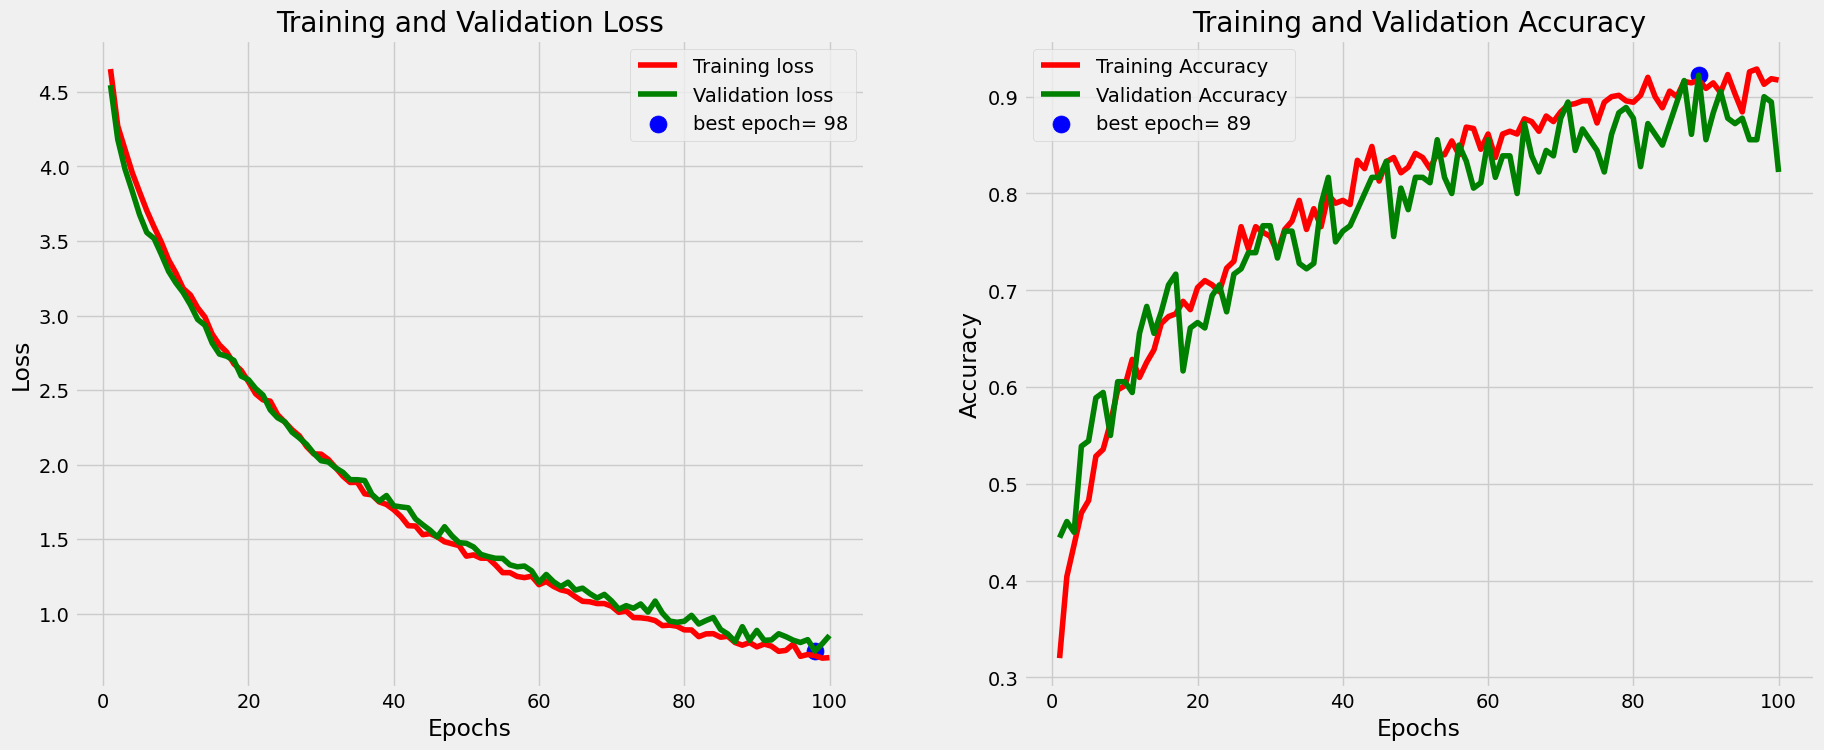

In [38]:
plot_training_history(history_emo)

## **4.4.** Model Evaluation

In [39]:
evaluate_model(model_emo, test_df_emo, train_gen_emo, valid_gen_emo, test_gen_emo)

2/2 [==============================] - 4s 2s/step - loss: 0.7628 - accuracy: 0.8750
Train Loss:  0.5284980535507202
Train Accuracy:  1.0
--------------------
Test Loss:  0.7627673745155334
Test Accuracy:  0.875


In [40]:
preds_emo = model_emo.predict(test_gen_emo)
y_pred_emo = np.argmax(preds_emo, axis=1)

2/2 [==============================] - 6s 2s/step


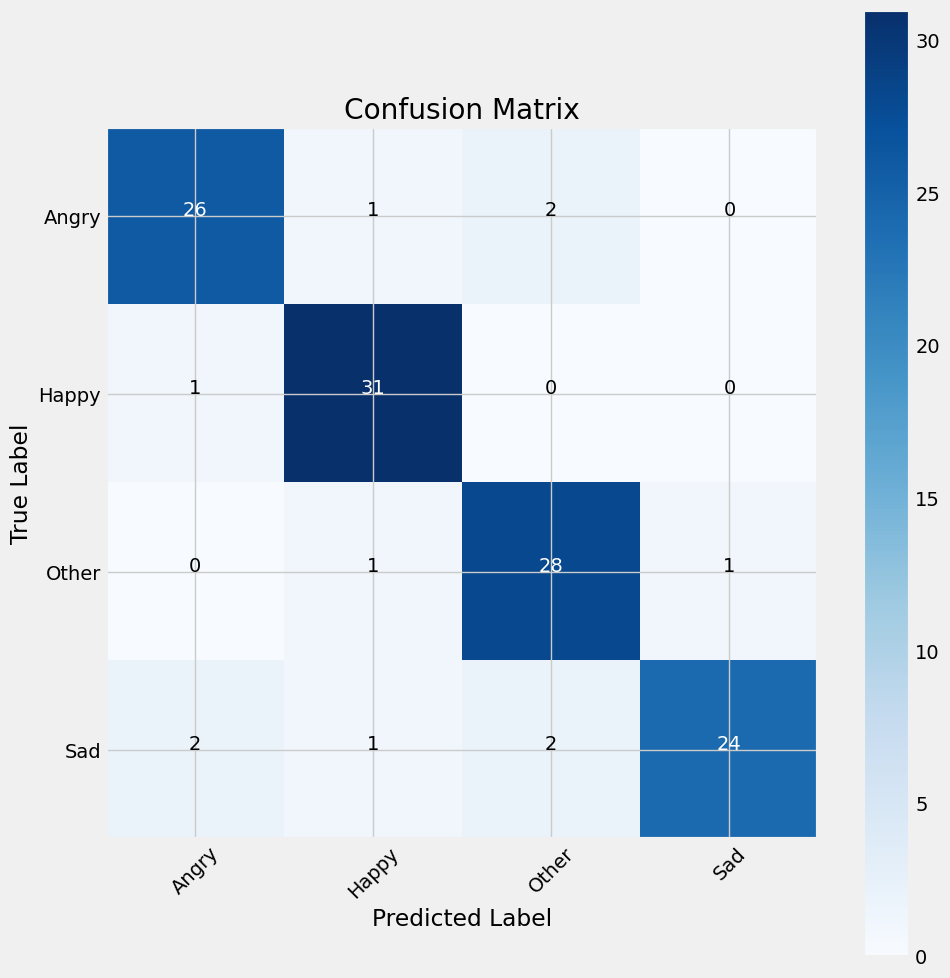

In [41]:
g_dict = test_gen_emo.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen_emo.classes, y_pred_emo)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [42]:
print(classification_report(test_gen_emo.classes, y_pred_emo, target_names= classes))

              precision    recall  f1-score   support

       Angry       0.90      0.90      0.90        29
       Happy       0.91      0.97      0.94        32
       Other       0.88      0.93      0.90        30
         Sad       0.96      0.83      0.89        29

    accuracy                           0.91       120
   macro avg       0.91      0.91      0.91       120
weighted avg       0.91      0.91      0.91       120



## **4.5.** Save Model

In [54]:
model_emo.save('Animal_emotion_model.h5')

#with open('Animal_emotion_model.pkl', 'wb') as file:
#    pickle.dump(model_emo, file)

# **5.** Prediction

1/1 [==============================] - 1s 1s/step


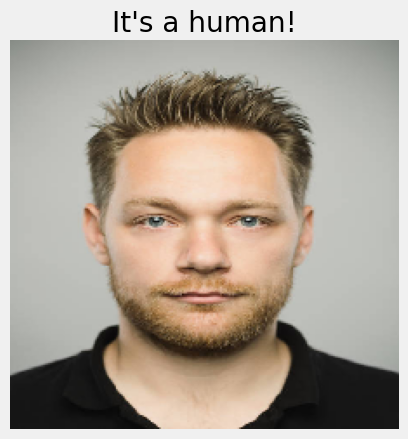

1/1 [==============================] - 1s 1s/step


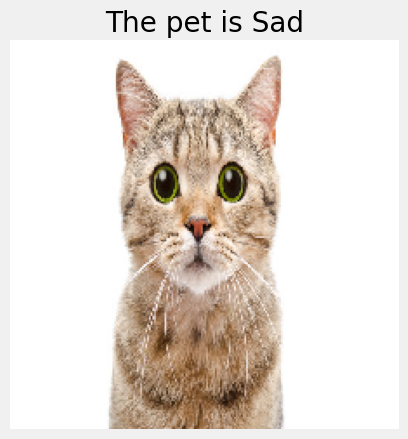

In [53]:
def predict_pet_or_human(image_path, pet_model, emotion_model):
    # Load the image and preprocess it
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    # Use Animal_Human_model to predict whether it's a pet or human
    pet_prediction = pet_model.predict(img_array)
    is_pet = pet_prediction[0][0] > 0.5  # Adjust the threshold as needed

    if is_pet:
        # If it's a pet, use Pets_Facial_Expression_model to predict emotion
        emotion_prediction = emotion_model.predict(img_array)
        emotion_class_index = np.argmax(emotion_prediction)
        class_labels = ['Angry', 'Other', 'Sad', 'Happy']
        emotion_label = class_labels[emotion_class_index]

        plt.imshow(img)
        plt.axis('off')
        plt.title(f"The pet is {emotion_label}")
        plt.show()
    else:
        # If it's a human, you can add your logic here
        plt.imshow(img)
        plt.axis('off')
        plt.title("It's a human!")
        plt.show()

# Load Animal_Human_model and Pets_Facial_Expression_model
animal_human_model = load_model('Animal_Human_model.h5')
pets_emotion_model = load_model('Animal_emotion_model.h5')

#animal_human_model = pickle.load(open('Animal_Human_model.pkl', 'rb'))
#pets_emotion_model = pickle.load(open('Animal_emotion_model.pkl', 'rb'))

# Replace 'path_to_test_image' with the path to the image you want to test
predict_pet_or_human('human2.jpg', animal_human_model, pets_emotion_model)
predict_pet_or_human('animal2.jpg', animal_human_model, pets_emotion_model)